![example](images/director_shot.jpeg)

# Project Title

**Authors:** Student 1, Student 2, Student 3
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [26]:
# Import Relevant Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image

# Neural network libraries

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, losses, metrics, Input
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
np.random.seed(42)

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

## Ideas
1. FSM with one layer
    - Show with original data & augmented data
2. Next model: 
    - add two extra hidden layers
    - change to relu
    - try (L2) regularization & dropout
3. FSM CNN (with convolution)
4. Next CNN model, more convolutional layers and dropout
    - (assuming we're overfitting to train data) try regularization & dropout
    - futz with batch size and epochs


### Additional ideas
- AAB: try multiclass problem to identify viral, bacteria, or none

In [2]:
# # Running in Google Colab
# from google.colab import drive

# drive.mount('/content/gdrive')
# root_path = 'gdrive/My Drive/Colab Notebooks/Pneumonia/' 

In [27]:
# Running locally
root_path = '../'

In [28]:
train_path = root_path + 'data/chest_xray/train/'
test_path = root_path + 'data/chest_xray/test/'

In [29]:
idg = ImageDataGenerator(rescale=1/255, validation_split=0.20)
train_set = idg.flow_from_directory(train_path, 
                                    target_size=(128, 128), 
                                    color_mode='grayscale', 
                                    class_mode='binary', 
                                    subset='training')

validation_set = idg.flow_from_directory(train_path, 
                                         target_size=(128, 128), 
                                         color_mode='grayscale', 
                                         class_mode='binary', 
                                         subset='validation')

test_set = idg.flow_from_directory(test_path, 
                                   target_size=(128,128), 
                                   color_mode='grayscale', 
                                   class_mode='binary', 
                                   shuffle=False)
# idg.flow()

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [30]:
classes = pd.DataFrame(train_set.classes)
class_dict = {0:'Normal', 1:'Pneumonia'}
classes[0] = classes[0].map(class_dict)
classes.value_counts()

Pneumonia    3100
Normal       1073
dtype: int64

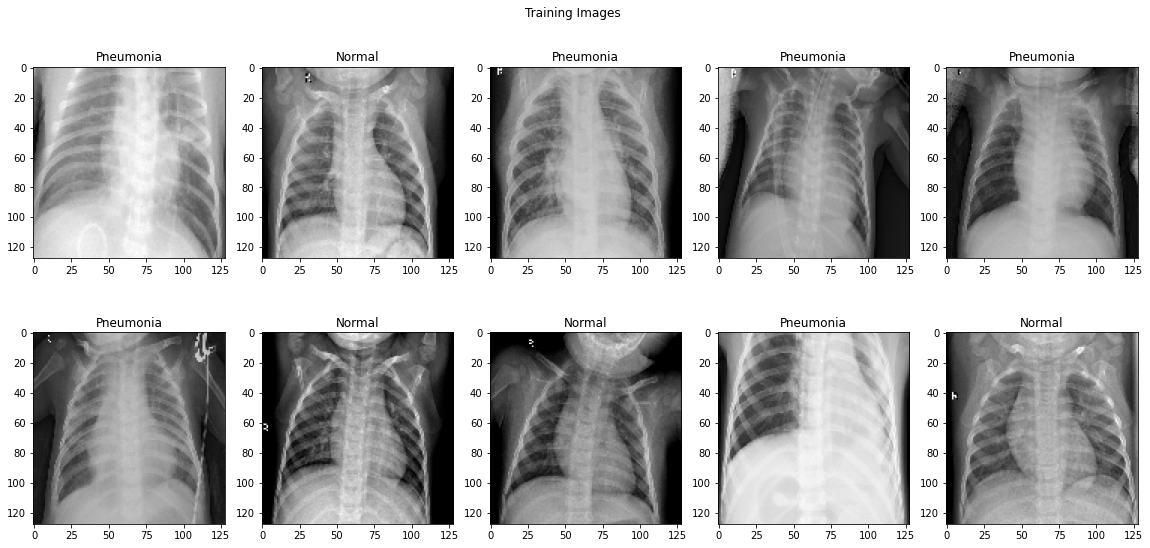

In [57]:
# # Visualize
train_images = train_set.next()
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

#train_images

for i in range(10):
    # Load image into numpy array and re-scale
    img = np.array(train_images[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5]
    ax.set_title(class_dict[train_images[1][i]])
    ax.imshow(img, cmap ='gray')
fig.suptitle('Training Images')
plt.tight_layout()
plt.savefig('../images/training_images_orig.jpg', transparent = False, bbox_inches="tight")

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

### DummyClassifier

In [32]:
train_target_size = train_set.image_shape[0:2]
train_batch_size  = train_set.n

test_target_size  = test_set.image_shape[0:2]
test_batch_size   = test_set.n



# Batch size set to the number of images found above in order to not batch data for the dummy model. Validation set not needed for dummy model
train_set_dummy = idg.flow_from_directory(train_path,
                                          target_size=train_target_size,
                                          color_mode='grayscale', 
                                          class_mode='binary', 
                                          subset='training', 
                                          batch_size=train_batch_size)

test_set_dummy  = idg.flow_from_directory(test_path, 
                                          target_size=test_target_size,
                                          color_mode='grayscale',
                                          class_mode='binary',
                                          shuffle=False,
                                          batch_size=test_batch_size)

# Split train and test dummy sets into images and corresponding labels for dummy model training
train_images, train_labels = next(train_set_dummy)
test_images, test_labels = next(test_set_dummy)

Found 4173 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
baseline_model = DummyClassifier(strategy= 'most_frequent')
baseline_model.fit(train_images, train_labels)

DummyClassifier(strategy='most_frequent')

Baseline accuracy: 0.625
Baseline recall: 1.0


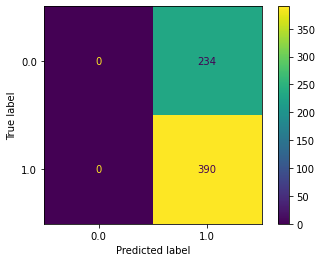

In [9]:
y_base_pred = baseline_model.predict(test_images)

base_accuracy = baseline_model.score(test_images, test_labels)
base_recall = recall_score(test_labels, y_base_pred)
print(f"Baseline accuracy: {base_accuracy}")
print(f"Baseline recall: {base_recall}")

plot_confusion_matrix(baseline_model, test_images, test_labels);

### First simple model

In [37]:
# here you run your code to model the data
fsm = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 1)),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])

fsm.compile(optimizer='SGD',
                           loss='binary_crossentropy',
                           metrics=['accuracy', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'AUC'])



In [38]:
first_simple_model_results = first_simple_model.fit(train_set, #train_set_aug, 
                           epochs=20,
                           batch_size=None, 
                           verbose=1, 
                           validation_data=validation_set)

Epoch 1/20
131/131 [==============================] - 40s 309ms/step - loss: 0.4673 - accuracy: 0.7812 - recall: 0.9961 - precision: 0.7741 - true_positives: 3088.0000 - true_negatives: 172.0000 - false_positives: 901.0000 - false_negatives: 12.0000 - auc: 0.8346 - val_loss: 0.3912 - val_accuracy: 0.8035 - val_recall: 0.9974 - val_precision: 0.7920 - val_true_positives: 773.0000 - val_true_negatives: 65.0000 - val_false_positives: 203.0000 - val_false_negatives: 2.0000 - val_auc: 0.9329
Epoch 2/20
131/131 [==============================] - 39s 300ms/step - loss: 0.3314 - accuracy: 0.8759 - recall: 0.9800 - precision: 0.8695 - true_positives: 3038.0000 - true_negatives: 617.0000 - false_positives: 456.0000 - false_negatives: 62.0000 - auc: 0.9482 - val_loss: 0.4172 - val_accuracy: 0.8236 - val_recall: 0.7948 - val_precision: 0.9610 - val_true_positives: 616.0000 - val_true_negatives: 243.0000 - val_false_positives: 25.0000 - val_false_negatives: 159.0000 - val_auc: 0.9412
Epoch 3/20
131

Epoch 18/20
131/131 [==============================] - 41s 309ms/step - loss: 0.1225 - accuracy: 0.9576 - recall: 0.9739 - precision: 0.9692 - true_positives: 3019.0000 - true_negatives: 977.0000 - false_positives: 96.0000 - false_negatives: 81.0000 - auc: 0.9893 - val_loss: 0.1526 - val_accuracy: 0.9425 - val_recall: 0.9768 - val_precision: 0.9474 - val_true_positives: 757.0000 - val_true_negatives: 226.0000 - val_false_positives: 42.0000 - val_false_negatives: 18.0000 - val_auc: 0.9832
Epoch 19/20
131/131 [==============================] - 41s 312ms/step - loss: 0.1231 - accuracy: 0.9573 - recall: 0.9732 - precision: 0.9695 - true_positives: 3017.0000 - true_negatives: 978.0000 - false_positives: 95.0000 - false_negatives: 83.0000 - auc: 0.9892 - val_loss: 0.1510 - val_accuracy: 0.9425 - val_recall: 0.9768 - val_precision: 0.9474 - val_true_positives: 757.0000 - val_true_negatives: 226.0000 - val_false_positives: 42.0000 - val_false_negatives: 18.0000 - val_auc: 0.9836
Epoch 20/20
13

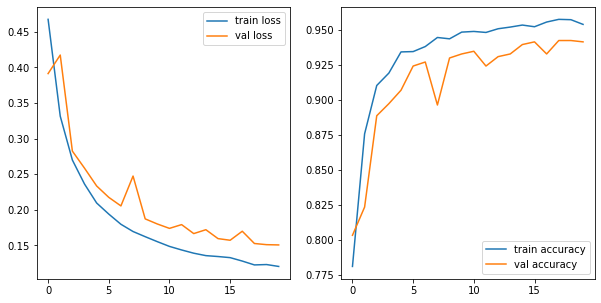

In [59]:
sigmoid_loss = first_simple_model_results.history['loss']
sigmoid_accuracy = first_simple_model_results.history['accuracy']
val_loss = first_simple_model_results.history['val_loss']
val_accuracy = first_simple_model_results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=first_simple_model_results.epoch, y=sigmoid_loss, ax=ax1, label='train loss')
sns.lineplot(x=first_simple_model_results.epoch, y=sigmoid_accuracy, ax=ax2, label='train accuracy')
sns.lineplot(x=first_simple_model_results.epoch, y=val_loss, ax=ax1, label='val loss')
sns.lineplot(x=first_simple_model_results.epoch, y=val_accuracy, ax=ax2, label='val accuracy')
ax1.legend();
plt.savefig('../images/training_performance_first_simple_model.jpg', transparent = False, bbox_inches="tight")

In [40]:
first_simple_model.evaluate(test_set)

20/20 [==============================] - 4s 197ms/step - loss: 0.6069 - accuracy: 0.7676 - recall: 0.9821 - precision: 0.7351 - true_positives: 383.0000 - true_negatives: 96.0000 - false_positives: 138.0000 - false_negatives: 7.0000 - auc: 0.9087


[0.6068540811538696,
 0.7676281929016113,
 0.9820512533187866,
 0.7351247668266296,
 383.0,
 96.0,
 138.0,
 7.0,
 0.9087058305740356]

In [58]:
output_path = root_path + 'data/first_simple_model.h5'
first_simple_model.save(output_path)

# Appears that you also need to save history separately (untested)
# convert results.history to csv and save it out
hist_df = pd.DataFrame(first_simple_model_results.history)
hist_df.to_csv(output_path.replace(".h5", ".csv"), index=False)


# # https://stackoverflow.com/questions/47843265/how-can-i-get-a-keras-models-history-after-loading-it-from-a-file-in-python
# from keras.callbacks import CSVLogger
# csv_logger = CSVLogger('training.log', separator=',', append=False)
# model.fit(X_train, Y_train, callbacks=[csv_logger])

## Generate augmented data to force model to be more generalizable

In [41]:
train_idg = ImageDataGenerator(rescale=1/255,
                               validation_split = 0.20,
                               rotation_range=40, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')
                                   

train_set_aug = train_idg.flow_from_directory(train_path, target_size=(128, 128), 
                                         color_mode='grayscale', class_mode='binary', subset='training')

validation_set_aug = train_idg.flow_from_directory(train_path, target_size=(128, 128), 
                                         color_mode='grayscale', class_mode='binary', subset='validation')



Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [47]:
# here you run your code to model the data
first_simple_model_aug = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 1)),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])

first_simple_model_aug.compile(optimizer='SGD',
                           loss='binary_crossentropy',
                           metrics=['accuracy', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'AUC'])



In [48]:
first_simple_model_aug_results = first_simple_model_aug.fit(
    train_set_aug, #train_set_aug, 
    epochs=100,
    batch_size=None, 
    verbose=1, 
    validation_data=validation_set_aug)

Epoch 1/100
131/131 [==============================] - 48s 365ms/step - loss: 0.5701 - accuracy: 0.7386 - recall: 0.9932 - precision: 0.7421 - true_positives: 3079.0000 - true_negatives: 3.0000 - false_positives: 1070.0000 - false_negatives: 21.0000 - auc: 0.5426 - val_loss: 0.5547 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.6506
Epoch 2/100
131/131 [==============================] - 47s 356ms/step - loss: 0.5534 - accuracy: 0.7436 - recall: 1.0000 - precision: 0.7434 - true_positives: 3100.0000 - true_negatives: 3.0000 - false_positives: 1070.0000 - false_negatives: 0.0000e+00 - auc: 0.6173 - val_loss: 0.5529 - val_accuracy: 0.7459 - val_recall: 1.0000 - val_precision: 0.7452 - val_true_positives: 775.0000 - val_true_negatives: 3.0000 - val_false_positives: 265.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.6838
Epo

Epoch 18/100
131/131 [==============================] - 47s 356ms/step - loss: 0.4867 - accuracy: 0.7762 - recall: 0.9806 - precision: 0.7767 - true_positives: 3040.0000 - true_negatives: 199.0000 - false_positives: 874.0000 - false_negatives: 60.0000 - auc: 0.7681 - val_loss: 0.4943 - val_accuracy: 0.7536 - val_recall: 0.9729 - val_precision: 0.7616 - val_true_positives: 754.0000 - val_true_negatives: 32.0000 - val_false_positives: 236.0000 - val_false_negatives: 21.0000 - val_auc: 0.7648
Epoch 19/100
131/131 [==============================] - 46s 352ms/step - loss: 0.4855 - accuracy: 0.7738 - recall: 0.9729 - precision: 0.7781 - true_positives: 3016.0000 - true_negatives: 213.0000 - false_positives: 860.0000 - false_negatives: 84.0000 - auc: 0.7677 - val_loss: 0.5055 - val_accuracy: 0.7632 - val_recall: 0.9135 - val_precision: 0.7973 - val_true_positives: 708.0000 - val_true_negatives: 88.0000 - val_false_positives: 180.0000 - val_false_negatives: 67.0000 - val_auc: 0.7598
Epoch 20/1

Epoch 35/100
131/131 [==============================] - 47s 360ms/step - loss: 0.4742 - accuracy: 0.7831 - recall: 0.9606 - precision: 0.7918 - true_positives: 2978.0000 - true_negatives: 290.0000 - false_positives: 783.0000 - false_negatives: 122.0000 - auc: 0.7777 - val_loss: 0.4712 - val_accuracy: 0.7814 - val_recall: 0.9600 - val_precision: 0.7906 - val_true_positives: 744.0000 - val_true_negatives: 71.0000 - val_false_positives: 197.0000 - val_false_negatives: 31.0000 - val_auc: 0.7845
Epoch 36/100
131/131 [==============================] - 48s 365ms/step - loss: 0.4689 - accuracy: 0.7838 - recall: 0.9487 - precision: 0.7983 - true_positives: 2941.0000 - true_negatives: 330.0000 - false_positives: 743.0000 - false_negatives: 159.0000 - auc: 0.7868 - val_loss: 0.4744 - val_accuracy: 0.7709 - val_recall: 0.9355 - val_precision: 0.7932 - val_true_positives: 725.0000 - val_true_negatives: 79.0000 - val_false_positives: 189.0000 - val_false_negatives: 50.0000 - val_auc: 0.7897
Epoch 37

131/131 [==============================] - 48s 364ms/step - loss: 0.4399 - accuracy: 0.7977 - recall: 0.9519 - precision: 0.8094 - true_positives: 2951.0000 - true_negatives: 378.0000 - false_positives: 695.0000 - false_negatives: 149.0000 - auc: 0.8233 - val_loss: 0.4690 - val_accuracy: 0.7728 - val_recall: 0.9665 - val_precision: 0.7802 - val_true_positives: 749.0000 - val_true_negatives: 57.0000 - val_false_positives: 211.0000 - val_false_negatives: 26.0000 - val_auc: 0.7923
Epoch 52/100
131/131 [==============================] - 48s 368ms/step - loss: 0.4520 - accuracy: 0.7949 - recall: 0.9481 - precision: 0.8088 - true_positives: 2939.0000 - true_negatives: 378.0000 - false_positives: 695.0000 - false_negatives: 161.0000 - auc: 0.8075 - val_loss: 0.4550 - val_accuracy: 0.7958 - val_recall: 0.9510 - val_precision: 0.8081 - val_true_positives: 737.0000 - val_true_negatives: 93.0000 - val_false_positives: 175.0000 - val_false_negatives: 38.0000 - val_auc: 0.8071
Epoch 53/100
131/131 

Epoch 68/100
131/131 [==============================] - 86s 660ms/step - loss: 0.4320 - accuracy: 0.8107 - recall: 0.9506 - precision: 0.8223 - true_positives: 2947.0000 - true_negatives: 436.0000 - false_positives: 637.0000 - false_negatives: 153.0000 - auc: 0.8279 - val_loss: 0.4519 - val_accuracy: 0.7881 - val_recall: 0.9006 - val_precision: 0.8290 - val_true_positives: 698.0000 - val_true_negatives: 124.0000 - val_false_positives: 144.0000 - val_false_negatives: 77.0000 - val_auc: 0.8110
Epoch 69/100
131/131 [==============================] - 81s 616ms/step - loss: 0.4253 - accuracy: 0.8092 - recall: 0.9484 - precision: 0.8221 - true_positives: 2940.0000 - true_negatives: 437.0000 - false_positives: 636.0000 - false_negatives: 160.0000 - auc: 0.8351 - val_loss: 0.4362 - val_accuracy: 0.8063 - val_recall: 0.9548 - val_precision: 0.8159 - val_true_positives: 740.0000 - val_true_negatives: 101.0000 - val_false_positives: 167.0000 - val_false_negatives: 35.0000 - val_auc: 0.8222
Epoch 

131/131 [==============================] - 71s 542ms/step - loss: 0.4176 - accuracy: 0.8198 - recall: 0.9494 - precision: 0.8318 - true_positives: 2943.0000 - true_negatives: 478.0000 - false_positives: 595.0000 - false_negatives: 157.0000 - auc: 0.8422 - val_loss: 0.4503 - val_accuracy: 0.7852 - val_recall: 0.9213 - val_precision: 0.8141 - val_true_positives: 714.0000 - val_true_negatives: 105.0000 - val_false_positives: 163.0000 - val_false_negatives: 61.0000 - val_auc: 0.8127
Epoch 85/100
131/131 [==============================] - 70s 538ms/step - loss: 0.4098 - accuracy: 0.8188 - recall: 0.9487 - precision: 0.8313 - true_positives: 2941.0000 - true_negatives: 476.0000 - false_positives: 597.0000 - false_negatives: 159.0000 - auc: 0.8516 - val_loss: 0.4576 - val_accuracy: 0.7872 - val_recall: 0.9523 - val_precision: 0.7996 - val_true_positives: 738.0000 - val_true_negatives: 83.0000 - val_false_positives: 185.0000 - val_false_negatives: 37.0000 - val_auc: 0.7978
Epoch 86/100
131/131

131/131 [==============================] - 74s 562ms/step - loss: 0.4013 - accuracy: 0.8253 - recall: 0.9516 - precision: 0.8359 - true_positives: 2950.0000 - true_negatives: 494.0000 - false_positives: 579.0000 - false_negatives: 150.0000 - auc: 0.8577 - val_loss: 0.4388 - val_accuracy: 0.7910 - val_recall: 0.9200 - val_precision: 0.8205 - val_true_positives: 713.0000 - val_true_negatives: 112.0000 - val_false_positives: 156.0000 - val_false_negatives: 62.0000 - val_auc: 0.8249


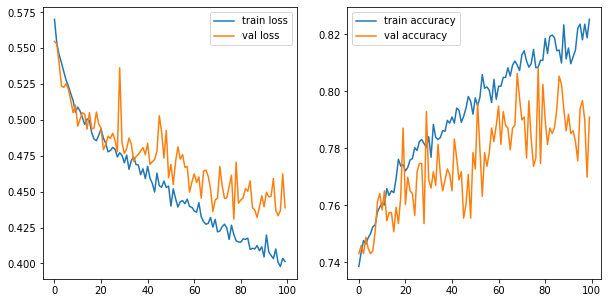

In [60]:
sigmoid_loss = first_simple_model_aug_results.history['loss']
sigmoid_accuracy = first_simple_model_aug_results.history['accuracy']
val_loss = first_simple_model_aug_results.history['val_loss']
val_accuracy = first_simple_model_aug_results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=first_simple_model_aug_results.epoch, y=sigmoid_loss, ax=ax1, label='train loss')
sns.lineplot(x=first_simple_model_aug_results.epoch, y=sigmoid_accuracy, ax=ax2, label='train accuracy')
sns.lineplot(x=first_simple_model_aug_results.epoch, y=val_loss, ax=ax1, label='val loss')
sns.lineplot(x=first_simple_model_aug_results.epoch, y=val_accuracy, ax=ax2, label='val accuracy')
ax1.legend();
plt.savefig('../images/training_performance_first_simple_model_aug.jpg', transparent = False, bbox_inches="tight")

In [50]:
first_simple_model_aug.evaluate(test_set)

20/20 [==============================] - 4s 213ms/step - loss: 0.4952 - accuracy: 0.7179 - recall: 0.8897 - precision: 0.7229 - true_positives: 347.0000 - true_negatives: 101.0000 - false_positives: 133.0000 - false_negatives: 43.0000 - auc: 0.8402


[0.4952313303947449,
 0.7179487347602844,
 0.8897435665130615,
 0.7229166626930237,
 347.0,
 101.0,
 133.0,
 43.0,
 0.8401654958724976]

In [55]:
output_path = root_path + 'data/first_simple_model_aug.h5'
first_simple_model_aug.save(output_path)

# Appears that you also need to save history separately (untested)
# convert results.history to csv and save it out
hist_df = pd.DataFrame(first_simple_model_aug_results.history)
hist_df.to_csv(output_path.replace(".h5", ".csv"), index=False)


# # https://stackoverflow.com/questions/47843265/how-can-i-get-a-keras-models-history-after-loading-it-from-a-file-in-python
# from keras.callbacks import CSVLogger
# csv_logger = CSVLogger('training.log', separator=',', append=False)
# model.fit(X_train, Y_train, callbacks=[csv_logger])

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***